In [1]:
import pandas as pd 
import numpy as np
import glob
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

Discussion
==========

After using an initial linear regression approach to predict return values, I changed the problem definition 
to predict the direction of the SPX for different return periods based on the feature set. 
This seemed conceptually simpler to do. To do this I encoded the sign of returns for a given return period 
and the problem is simply to classify the target as positive or negative. The hypothesis suggests the sign of the future return may be sufficient information to trade on.  

Since the problem shifted to a classification problem I dropped the linear regression model and instead opted for several linear classifiers. I honestly don't know which model is the 'best' for which types of data and since the target variable is pretty equally balanced between positive and negative this 'kitchen sink' approach seemed like an appropriate strategy. The pipeline approach simply lets me swap in different models relatively easily. 

The pipeline fits, predicts, evaluates the models and uses walk-forward train-test split so that the models would be able to see different temporally ordered sections of the data. I dropped two of the datasets to increase time to learn the data. In terms of pure model evaluation, they were scored according to precision, recall, accuracy and F1 score and each time fold. The final model evaluation computes the mean for each of those summary statistics across the time folds, collapsing that dimension of the data, and presents a final model score for each return period. 

Model performance is better for T + 21 day returns in general. The critical point, however, the returns to a strategy informed by these models versus the actualy performance of the asset through time is evidence that the timing of your models accuracy matters. Accuracy on instances when gains/losses are large can overwhelm the aggregate affect a large volume of accurate predictions when gains/losses are small. 

This suggests that it matters when returns/losses exhibit behavior that exceeds some order of standard deviation. In order to understand this better, I decided to take a look at the binned data in 'Centroids' file. For each T + day return I encode return days that fell in bin 1 or 10 as a tail event. Initially, I simplify this problem to simply trying to predict a tail event on 'T + 21' with the tail-event encoded data of 'T + 3' and 'T + 10'. I apply the same pipeline as before, with the same temporal walk-forward validation of models. The performance of the models in general is only slightly better than the underlying distribution of tail event instances in the data. 

#run some ml stuff
#check the 'goodness' of the model
#normalize the columns, rerun and evaluate
#add in other columns and rerun, evaluate
#add in other columns normalize, rerun, evaluate
#feature engineer the columns

In [2]:
#helper function to make sense of excel serial date format
import datetime

def xldate_to_datetime(xldate):
    temp = datetime.datetime(1900, 1, 1)
    delta = datetime.timedelta(days=xldate)
    return temp+delta

In [326]:
#io
fls1 = glob.glob('/Users/livingdharma/Downloads/ProgrammingTest/*.txt')
fls2= glob.glob('/Users/livingdharma/Downloads/ProgrammingTest/*.TXT')
fls_all = fls1[:1] + fls2[:5] + fls2[6:]

In [13]:
#construct feature matrix
#two data sources have been excluded for initial analysis

def construct_feature_matrix(fls_all):
    '''
    Constructs a feature matrix after some data cleaning
    '''
    dfs = []
    for fl in fls_all:
        df = pd.read_csv(fl)
        col_name = df.columns[1]
        df['date'] = df['Lookup'].apply(xldate_to_datetime)
        df = df.drop('Lookup', axis=1)
        df = df.set_index(keys='date')
        dfs.append(df)

    feature_matrix = pd.concat([df for df in dfs], join='inner', axis=1)
    feature_matrix = feature_matrix.dropna()
    
    return feature_matrix

In [382]:
def evaluate_model(predictions,returns):
    '''
    
    '''
    comparison = pd.DataFrame()
    comparison['returns'] = returns
    comparison['prediction'] = predictions
    comparison['strategy'] = comparison['prediction'] * comparison['returns']
    
    return comparison

In [9]:
def clean_target(path):
    targets = pd.read_csv(path)
    targets['date'] = targets['Lookup'].apply(xldate_to_datetime)
    targets = targets.set_index(keys='date').drop('Lookup', axis=1).dropna()
    return targets

In [329]:
def onesdv(row):
    onesdv = 0
    if row < 3:
        onesdv = -1
    if row > 8:
        onesdv = 1
    return onesdv

In [466]:
feature_matrix = construct_feature_matrix(fls_all)
features = feature_matrix.columns
targets = clean_target('/Users/livingdharma/Downloads/ProgrammingTest/SpxFwdPct_Data.csv')
features_targets = pd.concat([feature_matrix, targets], join='inner', axis = 1)
features_targets = features_targets.dropna(axis=0)
#split = int(len(features_targets) * .6)

In [485]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#model imports 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.feature_selection import SelectFromModel



from sklearn.model_selection import TimeSeriesSplit

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(6),
    SVC(kernel="rbf", C=0.025, probability=True),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    BernoulliNB(),
    LinearDiscriminantAnalysis(),
    ]

# Logging for Visual Comparison
log_cols=["Day", "Classifier", "Fold", "Accuracy", "Precision", "Recall", "F1"]
log = pd.DataFrame(columns=log_cols)

model_test_period_returns = {}

#todo
for day in ["3", "10", "21"]:
    
    for clf in classifiers:
        
        name = clf.__class__.__name__
        
        
        tscv = TimeSeriesSplit(n_splits=10)
        fold = 1
        for train_index, test_index in tscv.split(features_targets[features]):
            #print(test_index)
            X_train = features_targets[features][:train_index[-1]]
            y_train = features_targets[day][:train_index[-1]]
            X_test = features_targets[features][train_index[-1]:]
            y_test = features_targets[day][train_index[-1]:]



            clf.fit(X_train, np.sign(y_train))

            test_predictions = clf.predict(X_test)
            acc = accuracy_score(np.sign(y_test.values), test_predictions)


            precision = precision_score(np.sign(y_test.values), test_predictions, average='micro')
            recall = recall_score(np.sign(y_test.values), test_predictions, average='micro')
            f1 = f1_score(np.sign(y_test.values), test_predictions, average='micro')
    


            log_entry = pd.DataFrame([[day, name, fold, acc*100, precision, recall, f1]], columns=log_cols)
            log_entry = log_entry.set_index(keys='Classifier')
            log = log.append(log_entry)
            fold += 1
        model_test_period_returns[str(name) + '_' + day ] = evaluate_model(test_predictions, features_targets[day][train_index[-1]:])

log = log.dropna(axis=1)

/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [478]:
log.head()

,Accuracy,Day,F1,Fold,Precision,Recall
LogisticRegression,49.579277,3,0.495793,1,0.495793,0.495793
LogisticRegression,56.461962,3,0.564620,2,0.564620,0.564620
LogisticRegression,56.176531,3,0.561765,3,0.561765,0.561765
LogisticRegression,55.668159,3,0.556682,4,0.556682,0.556682
LogisticRegression,55.430300,3,0.554303,5,0.554303,0.554303


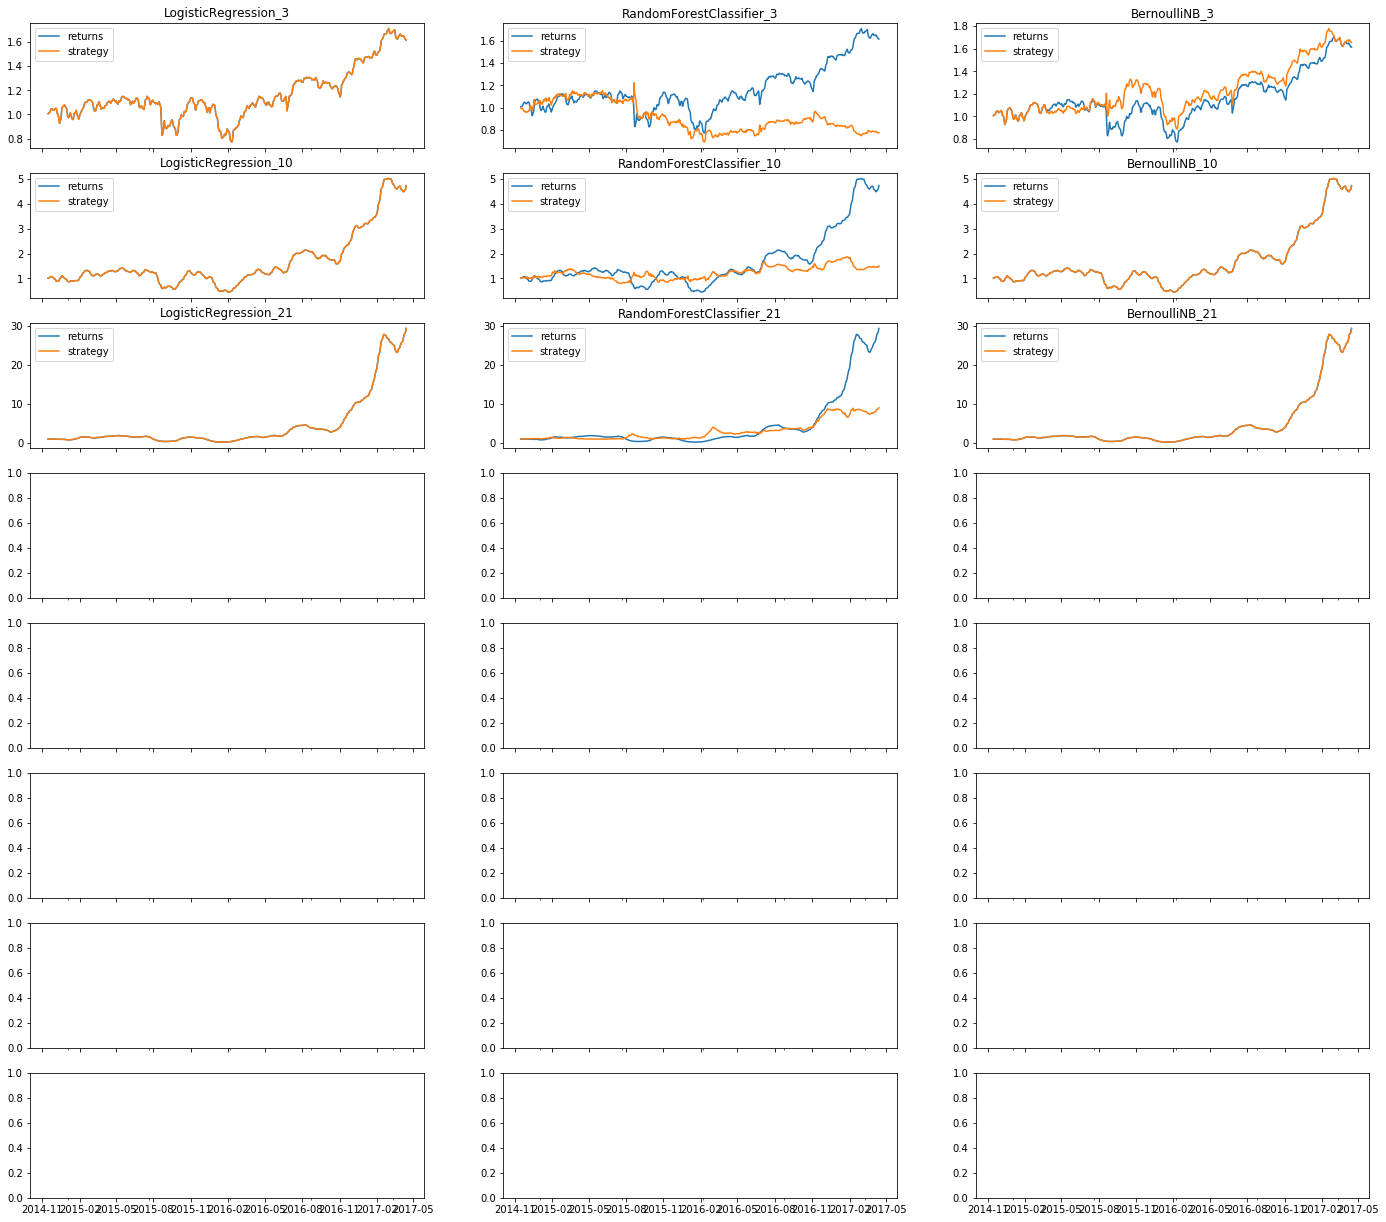

In [484]:
fig, axes = plt.subplots(8, 3, figsize=(24, 24), sharex=True)

for i, model in enumerate(model_test_period_returns.keys()):
    
    model_test_period_returns[model][['returns', 'strategy']].dropna().cumsum(
                ).apply(np.exp).plot(ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(model)

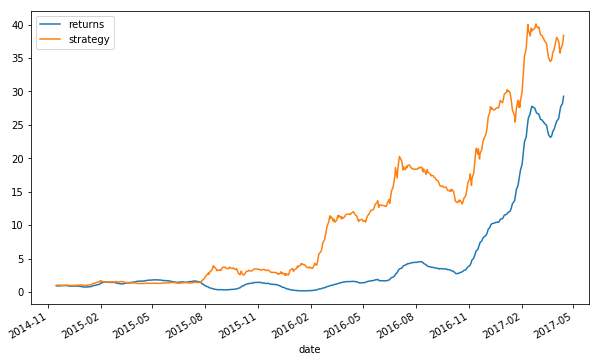

In [473]:
model_test_period_returns['RandomForestClassifier_21'][['returns', 'strategy']].dropna().cumsum(
                ).apply(np.exp).plot(figsize=(10,6))

In [392]:
centroids = pd.read_csv('/Users/livingdharma/Downloads/ProgrammingTest/spxFwdRetHistQCentroids.csv')
centroids['date'] = centroids['Date'].apply(xldate_to_datetime)
centroids.drop('Date', axis=1, inplace=True)
centroids = centroids.set_index(keys='date')
centroids['onesdv_3'] = centroids['3'].apply(onesdv)
centroids['onesdv_10'] = centroids['10'].apply(onesdv)
centroids['onesdv_21'] = centroids['21'].apply(onesdv)
centroids['return_3'] = targets['3']
centroids['return_10'] = targets['10']
centroids['return_21'] = targets['21']
features_targets = pd.concat([feature_matrix, centroids], join='inner', axis = 1)
features_targets = features_targets.drop(['3', '10', '21'], axis =1)


In [435]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#model imports 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


from sklearn.model_selection import TimeSeriesSplit

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="rbf", C=0.025, probability=True),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    BernoulliNB(),
    LinearDiscriminantAnalysis(),
    ]

# Logging for Visual Comparison
log_cols=["Day", "Classifier", "Fold", "Accuracy", "Precision", "Recall", "F1"]
log = pd.DataFrame(columns=log_cols)

# test_pred_cols = ['Day', 'Classifier', 'Predictions']
# test_preds = pd.DataFrame(columns=test_pred_cols)

model_test_period_returns = {}


for day in ["onesdv_3", "onesdv_10", "onesdv_21"]:
    
    for clf in classifiers:
        
        name = clf.__class__.__name__
        
        tscv = TimeSeriesSplit(n_splits=10)
        fold = 1
        for train_index, test_index in tscv.split(features_targets[features]):
            
            #accounting
            X_train = features_targets[features][:train_index[-1]]
            y_train = features_targets[day][:train_index[-1]]
            X_test = features_targets[features][train_index[-1]:]
            y_test = features_targets[day][train_index[-1]:]


            #ml magic
            clf.fit(X_train, y_train)
            test_predictions = clf.predict(X_test)
        
            #compute our metrics
            acc = accuracy_score(y_test.values, test_predictions)
            precision = precision_score(y_test.values, test_predictions, average='micro')
            recall = recall_score(y_test.values, test_predictions, average='micro')
            f1 = f1_score(y_test.values, test_predictions, average='micro')
    

            #accounting and bookkeeping 
            log_entry = pd.DataFrame([[day, name, fold, acc*100, precision, recall, f1]], columns=log_cols)
            log_entry = log_entry.set_index(keys='Classifier')
            log = log.append(log_entry)
            fold += 1
        
        #lets see our models perform in the final test period
        model_test_period_returns[str(name) + '_' + day ] = evaluate_model(test_predictions, features_targets['return_' + day.split('_')[1]][train_index[-1]:])

log = log.dropna(axis=1)

/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/Users/livingdharma/miniconda2/envs/xarray-dev/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)


In [394]:
log.to_csv('onesdv_10_fold.csv')

In [395]:
log.groupby([log.index, 'Day']).mean()

Accuracy        F1  Precision    Recall
                           Day                                                
AdaBoostClassifier         onesdv_10  60.070726  0.600707   0.600707  0.600707
                           onesdv_21  62.697676  0.626977   0.626977  0.626977
                           onesdv_3   58.003454  0.580035   0.580035  0.580035
BernoulliNB                onesdv_10  59.561561  0.595616   0.595616  0.595616
                           onesdv_21  60.120473  0.601205   0.601205  0.601205
                           onesdv_3   55.578961  0.555790   0.555790  0.555790
GradientBoostingClassifier onesdv_10  60.493334  0.604933   0.604933  0.604933
                           onesdv_21  63.291630  0.632916   0.632916  0.632916
                           onesdv_3   59.325128  0.593251   0.593251  0.593251
KNeighborsClassifier       onesdv_10  54.021872  0.540219   0.540219  0.540219
                           onesdv_21  56.529612  0.565296   0.565296  0.565296
                           onesdv_3   51.442261  0.514423   0.514423  0.514423
LinearDiscriminantAnalysis onesdv_10  65.469392  0.654694   0.654694  0.654694
                           onesdv_21  66.820494  0.668205   0.668205  0.668205
                           onesdv_3   62.799505  0.627995   0.627995  0.627995
LogisticRegression         onesdv_10  67.387375  0.673874   0.673874  0.673874
                           onesdv_21  69.219985  0.692200   0.692200  0.692200
                           onesdv_3   64.655239  0.646552   0.646552  0.646552
RandomForestClassifier     onesdv_10  57.821068  0.578211   0.578211  0.578211
                           onesdv_21  59.387276  0.593873   0.593873  0.593873
                           onesdv_3   54.872099  0.548721   0.548721  0.548721
SVC                        onesdv_10  67.150165  0.671502   0.671502  0.671502
                           onesdv_21  69.406300  0.694063   0.694063  0.694063
                           onesdv_3   63.979502  0.639795   0.639795  0.639795

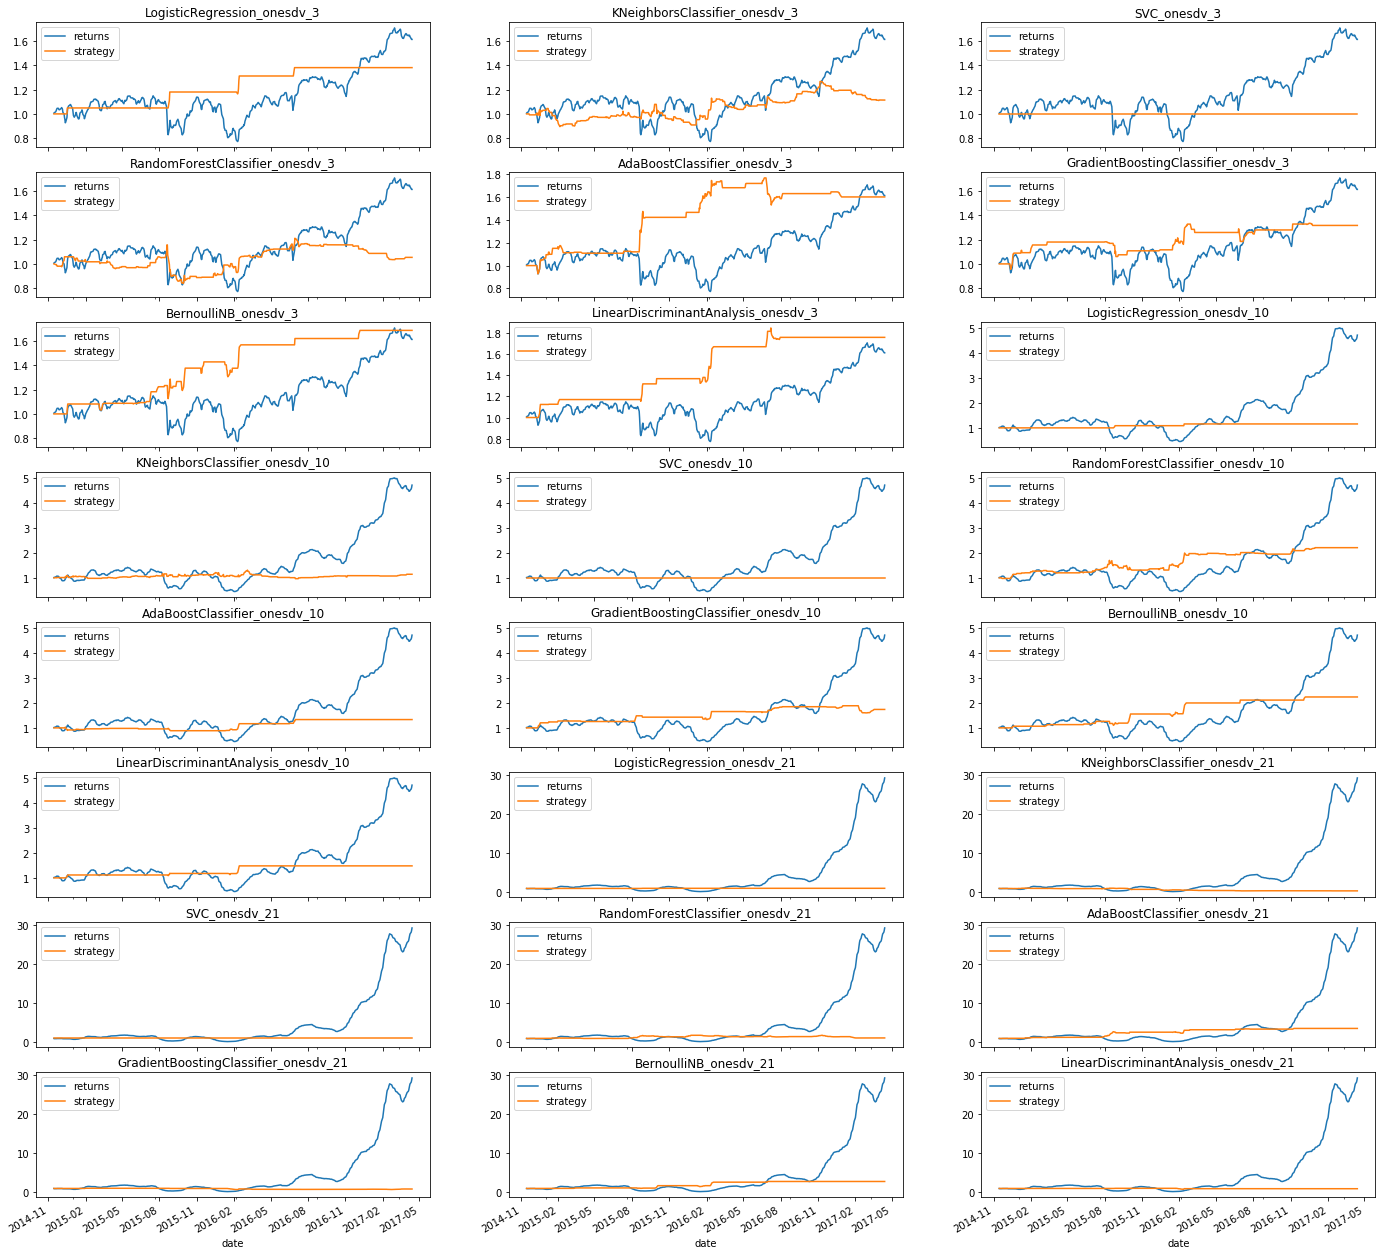

In [396]:
fig, axes = plt.subplots(8, 3, figsize=(24, 24), sharex=True)

for i, model in enumerate(model_test_period_returns.keys()):
    
    model_test_period_returns[model][['returns', 'strategy']].dropna().cumsum(
                ).apply(np.exp).plot(ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(model)

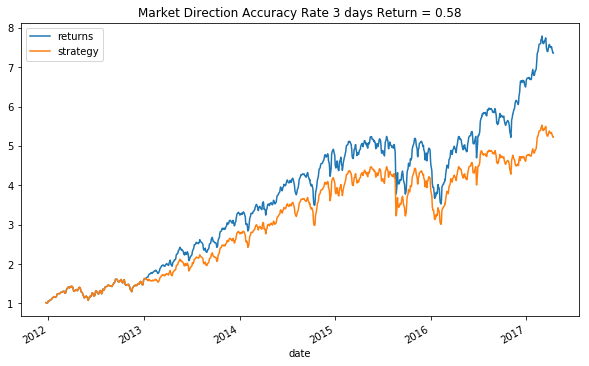

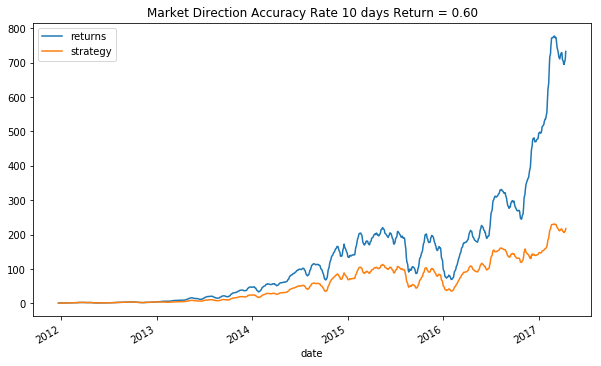

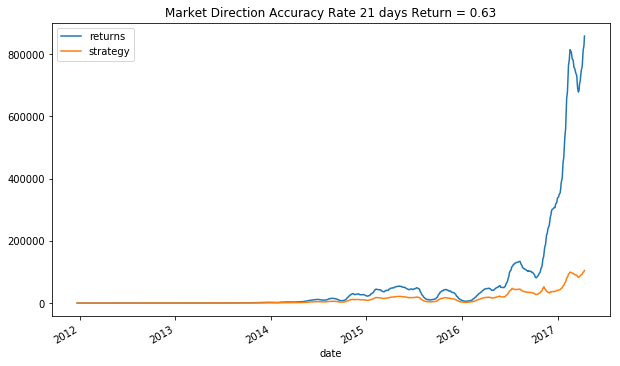

In [572]:
for i, rtrn in enumerate(['3', '10', '21']):
    X_train = features_targets[features][:split]
    y_train = features_targets[rtrn][:split]
    X_test = features_targets[features][split:]
    y_test = features_targets[rtrn][split:]
    model = fit_model(X_train, y_train)
    comparison = evaluate_model(model, X_test, y_test, rtrn)
    
    
    hits = np.sign(comparison['returns'] *
                        comparison['prediction']).value_counts()
    
    acc_rate = hits.values[0] / sum(hits)
    
    
    ax = comparison[['returns', 'strategy']].dropna().cumsum(
                ).apply(np.exp).plot(figsize=(10, 6))
    
    ax.set_title('Market Direction Accuracy Rate {} days Return = {:.2f}'.format(rtrn, acc_rate)) 